### NASNet-Mobile 
NASNet-Mobile is a convolutional neural network that is trained on more than a million images from the ImageNet database . The network can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals. ... The network has an image input size of 224-by-224

![](https://i.stack.imgur.com/h9TXi.jpg)





### Description of the dataset

The dataset contains 9 different seafood types. For each class, there are 1000 augmented images and their pair-wise augmented ground truths.
Each class can be found in the "Fish_Dataset" file with their ground truth labels. All images for each class are ordered from "00000.png" to "01000.png".

For example, if you want to access the ground truth images of the shrimp in the dataset, the order should be followed is "Fish->Shrimp->Shrimp GT".


### Dataset 

[Link](https://www.kaggle.com/crowww/a-large-scale-fish-dataset/code)


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import os.path
import tqdm
import glob
import tensorflow as tf
from pathlib import Path
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import to_categorical
from keras import optimizers
from tensorflow.keras.optimizers import Adam

from keras.callbacks import Callback,ModelCheckpoint,ReduceLROnPlateau
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

#import tensorflow_addons as tfa
#from tensorflow.keras.metrics import Metric
#from tensorflow_addons.utils.types import AcceptableDTypes, FloatTensorLike
from typeguard import typechecked
from typing import Optional

In [2]:
root_dir  =  Path('../input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset')

In [3]:
root_dir

PosixPath('../input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset')

In [4]:
# Get filepaths and Class
filepaths = list(root_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Class')

In [5]:
filepaths

0        ../input/a-large-scale-fish-dataset/Fish_Datas...
1        ../input/a-large-scale-fish-dataset/Fish_Datas...
2        ../input/a-large-scale-fish-dataset/Fish_Datas...
3        ../input/a-large-scale-fish-dataset/Fish_Datas...
4        ../input/a-large-scale-fish-dataset/Fish_Datas...
                               ...                        
17995    ../input/a-large-scale-fish-dataset/Fish_Datas...
17996    ../input/a-large-scale-fish-dataset/Fish_Datas...
17997    ../input/a-large-scale-fish-dataset/Fish_Datas...
17998    ../input/a-large-scale-fish-dataset/Fish_Datas...
17999    ../input/a-large-scale-fish-dataset/Fish_Datas...
Name: Filepath, Length: 18000, dtype: object

In [6]:
labels

0         Hourse Mackerel
1         Hourse Mackerel
2         Hourse Mackerel
3         Hourse Mackerel
4         Hourse Mackerel
               ...       
17995    Red Sea Bream GT
17996    Red Sea Bream GT
17997    Red Sea Bream GT
17998    Red Sea Bream GT
17999    Red Sea Bream GT
Name: Class, Length: 18000, dtype: object

In [7]:
# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Drop GT images
image_df['Class'] = image_df['Class'].apply(lambda x: np.NaN if x[-2:] == 'GT' else x)
image_df = image_df.dropna(axis=0)

In [8]:
# Sample 200 images from each class
samples = []

for category in image_df['Class'].unique():
    category_slice = image_df.query("Class == @category")
    samples.append(category_slice.sample(200, random_state=1))

image_df = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)

In [9]:
image_df

,Filepath,Class
0,../input/a-large-scale-fish-dataset/Fish_Datas...,Gilt-Head Bream
1,../input/a-large-scale-fish-dataset/Fish_Datas...,Sea Bass
2,../input/a-large-scale-fish-dataset/Fish_Datas...,Red Mullet
3,../input/a-large-scale-fish-dataset/Fish_Datas...,Shrimp
4,../input/a-large-scale-fish-dataset/Fish_Datas...,Trout
...,...,...
1795,../input/a-large-scale-fish-dataset/Fish_Datas...,Trout
1796,../input/a-large-scale-fish-dataset/Fish_Datas...,Red Sea Bream
1797,../input/a-large-scale-fish-dataset/Fish_Datas...,Striped Red Mullet
1798,../input/a-large-scale-fish-dataset/Fish_Datas...,Black Sea Sprat


In [10]:
x_train, x_test = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=1)

In [11]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [12]:
train_images = train_generator.flow_from_dataframe(
    dataframe=x_train,
    x_col='Filepath',
    y_col='Class',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)


Found 1152 validated image filenames belonging to 9 classes.


In [13]:
val_images = train_generator.flow_from_dataframe(
    dataframe=x_train,
    x_col='Filepath',
    y_col='Class',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)



Found 288 validated image filenames belonging to 9 classes.


In [14]:
test_images = test_generator.flow_from_dataframe(
    dataframe=x_test,
    x_col='Filepath',
    y_col='Class',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 360 validated image filenames belonging to 9 classes.


In [15]:
base_model = tf.keras.applications.NASNetMobile(input_shape=(224,224,3),include_top=False,weights="imagenet")

19996672/19993432 [==============================] - 0s 0us/step


In [16]:
# Freezing Layers

for layer in base_model.layers[:-4]:
    layer.trainable=False

In [17]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(9,activation='softmax'))

In [18]:
# Model Summary

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Functional)          (None, 7, 7, 1056)        4269716   
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 1056)        0         
_________________________________________________________________
flatten (Flatten)            (None, 51744)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 51744)             206976    
_________________________________________________________________
dense (Dense)                (None, 32)                1655840   
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
activation_188 (Activation)  (None, 32)                0

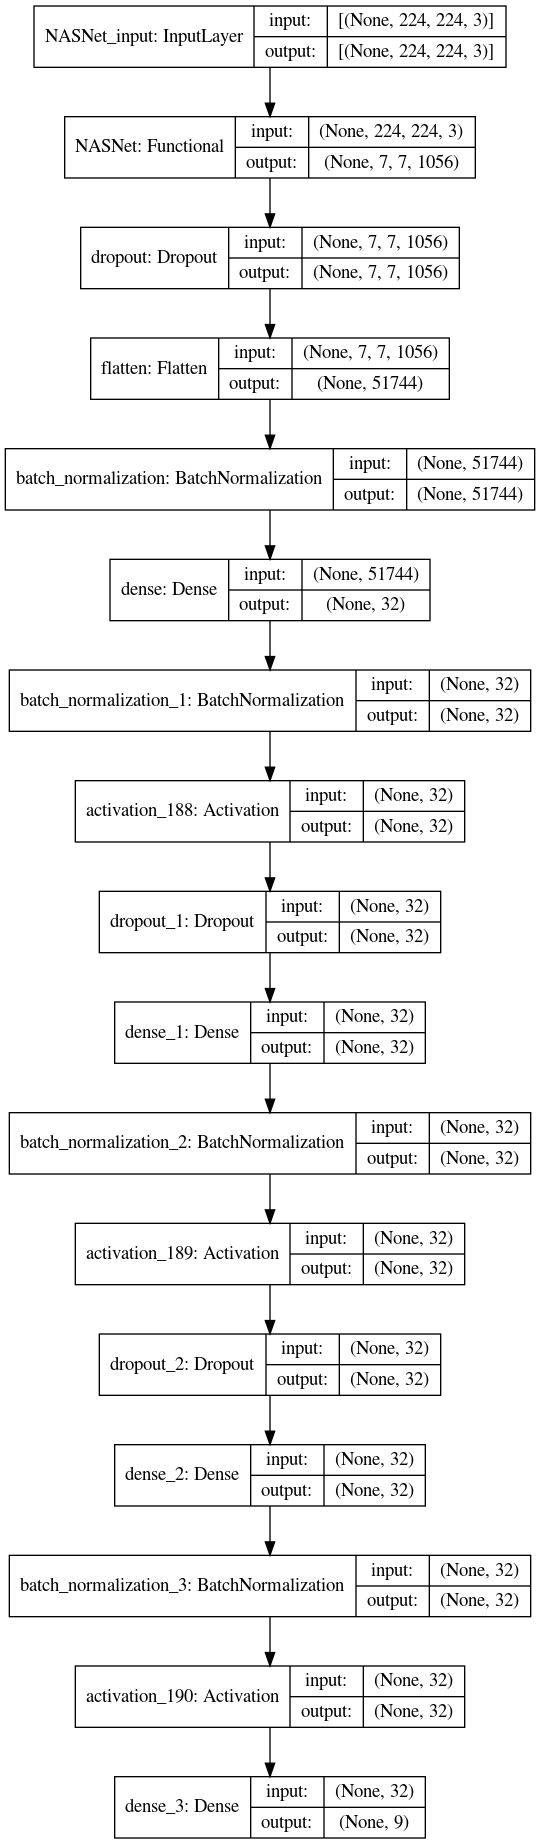

In [19]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png') 

In [20]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [21]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [22]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 2,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=1, patience=2)

In [23]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)

In [24]:
%time
history=model.fit(train_images,validation_data=val_images,epochs=15,verbose = 1,callbacks=[lrd,mcp,es])

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.87 µs
Epoch 1/15
36/36 [==============================] - 113s 3s/step - loss: 2.3262 - accuracy: 0.8873 - precision: 0.3333 - recall: 0.0147 - auc: 0.5660 - f1_score: 0.0278 - val_loss: 3.0258 - val_accuracy: 0.8615 - val_precision: 0.3216 - val_recall: 0.2222 - val_auc: 0.6862 - val_f1_score: 0.2614
Epoch 2/15
36/36 [==============================] - 82s 2s/step - loss: 1.9060 - accuracy: 0.8909 - precision: 0.6756 - recall: 0.0348 - auc: 0.7300 - f1_score: 0.0647 - val_loss: 1.4513 - val_accuracy: 0.9008 - val_precision: 0.6372 - val_recall: 0.2500 - val_auc: 0.8650 - val_f1_score: 0.3523
Epoch 3/15
36/36 [==============================] - 83s 2s/step - loss: 1.7762 - accuracy: 0.8941 - precision: 0.7657 - recall: 0.0679 - auc: 0.7855 - f1_score: 0.1237 - val_loss: 1.1657 - val_accuracy: 0.9147 - val_precision: 0.8526 - val_recall: 0.2812 - val_auc: 0.9379 - val_f1_score: 0.4144
Epoch 4/15
36/36 [=============================

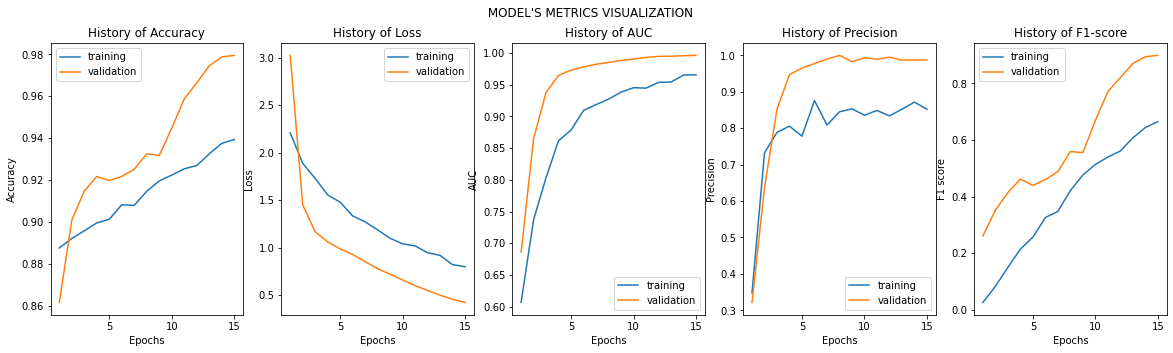

In [25]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )


In [26]:
model.evaluate(test_images)

12/12 [==============================] - 22s 2s/step - loss: 0.3676 - accuracy: 0.9818 - precision: 0.9871 - recall: 0.8472 - auc: 0.9981 - f1_score: 0.9063


[0.36760398745536804,
 0.9817901849746704,
 0.9870550036430359,
 0.8472222089767456,
 0.9980564713478088,
 0.9063132405281067]

### If you want help plz contact me

Yasserhesseinshakir@yahoo.com

https://www.linkedin.com/in/yasir-hussein-314a65201/

https://www.kaggle.com/yasserhessein

Refeneces

https://keras.io/